  Forecasting HICP Seasonal Time Series using Python and SARIMAX

------------------------------------Dataset-----------------------------------------------------------
 
 Harmonised index of consumer prices (HICP) is a consumer price index calculated according to a methodology harmonised across the European Union (EU). The HICPs produced by each EU member state are used to measure inflation in the EU, make international comparisons between the EU Member States, implement the monetary policy of the European Central Bank, calculate the European index of consumer prices, the Monetary Union index of consumer prices, and the European Economic Area index of consumer prices. The country’s compliance with the price stability criterion is assessed taking into consideration the HICP - based inflation rate. The HICP can be regarded as an indicator showing the amount the average consumer would have to spend in a given year to buy the same basic goods and services for which one would have to pay 100 monetary units in the reference period. 
  Index reference period – the reference period with the index equated to 100 points. Having the time series of price indices, calculated with a single index reference period, it is possible to determine the HICP for different periods.  
  
  We will use HICP dataset of all EU member states, published in official Eurostat database:        https://ec.europa.eu/eurostat/data/database
  
-----------------------------------Analysis plan--------------------------------------------------------
  
   Economic or financial theory
   
    Economic model formulation
                
     Data mining and cleaning
                
         Model evaluation
                
       Model Interpretation
                
        Model application
                
        Results evaluation
--------------------------------- About model----------------------------------------------------------
 
 Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting. Although the method can handle data with a trend, it does not support time series with a seasonal component. An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.
We will use the Seasonal Autoregressive Integrated Moving Average, or SARIMA, method for time series HICP forecasting with univariate data containing trends and seasonality.



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline    
import warnings
warnings.filterwarnings('ignore')
plt.style.use('Solarize_Light2') 
from pylab import rcParams

In [17]:
data=pd.read_excel("./data/madde sepeti ve ortalama madde fiyatlari (turkiye).xls")
food=data.iloc[5:422]


In [42]:
dates= pd.date_range('2003-01-01','2022-05-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()
df["TIME"]=dates
m=food.mean(axis=0)
df["Value"]=m.values
df

,TIME,Value
0,2003-01-01,1.606226e+08
1,2003-02-01,1.635402e+08
2,2003-03-01,1.643173e+08
3,2003-04-01,1.680741e+08
4,2003-05-01,1.667277e+08
...,...,...
227,2021-12-01,3.352657e+03
228,2022-01-01,3.724935e+03
229,2022-02-01,3.800657e+03
230,2022-03-01,3.998321e+03


In [43]:
df.iloc[0:24,1]=df.iloc[0:24,1]/1e+6
df=df.set_index(dates)
df

,TIME,Value
2003-01-01,2003-01-01,160.622607
2003-02-01,2003-02-01,163.540217
2003-03-01,2003-03-01,164.317261
2003-04-01,2003-04-01,168.074085
2003-05-01,2003-05-01,166.727683
...,...,...
2021-12-01,2021-12-01,3352.656670
2022-01-01,2022-01-01,3724.934816
2022-02-01,2022-02-01,3800.656652
2022-03-01,2022-03-01,3998.321061


In [44]:
df.info()   # time as object, need convert to data_time format

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2003-01-01 to 2022-04-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    232 non-null    datetime64[ns]
 1   Value   232 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.4 KB


In [45]:
df['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df['TIME'] =  pd.to_datetime(df['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df = df.set_index(['TIME'])

In [46]:
df.index

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01'],
              dtype='datetime64[ns]', name='TIME', length=232, freq=None)

In [47]:
df[pd.isnull(df['Value'])].count()
df['Value']=df['Value'].astype(float)


Text(0.5, 1.0, 'Average Food Prices(₺)')

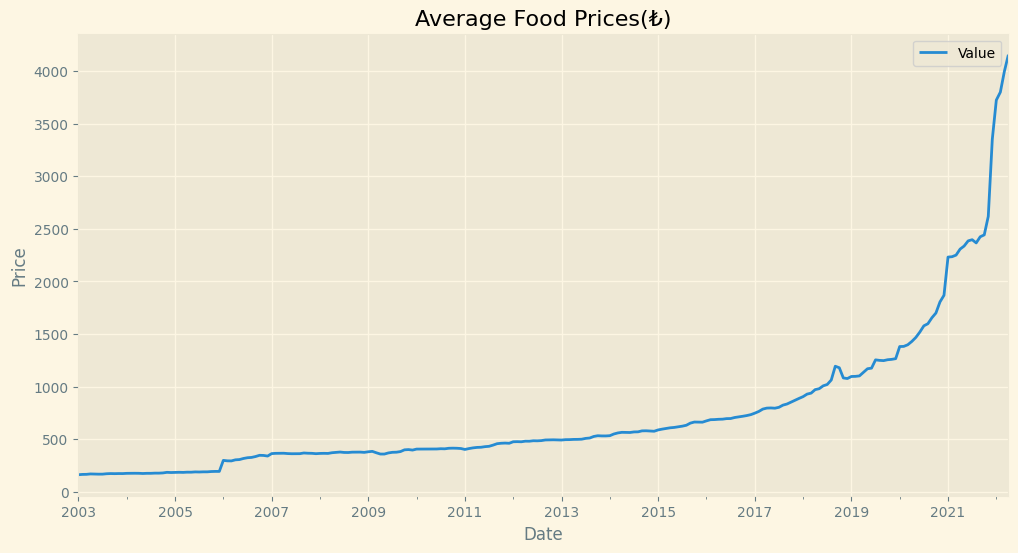

In [50]:
# Resulting Plot
rcParams['figure.figsize'] = 12, 6
df.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Average Food Prices(₺)")

In [22]:
df.Value

TIME
2020-12-01     7.4320
2021-01-01     7.3099
2021-02-01     7.4226
2021-03-01     8.2439
2021-04-01     8.2735
2021-05-01     8.4808
2021-06-01     8.7037
2021-07-01     8.4333
2021-08-01     8.3045
2021-09-01     8.8862
2021-10-01     9.6030
2021-11-01    13.4732
2021-12-01    13.3161
2022-01-01    13.3074
2022-02-01    13.8443
2022-03-01    14.6700
2022-04-01    14.8416
2022-05-01    16.3748
2022-06-01    16.6933
2022-07-01    17.9114
2022-08-01    18.1868
2022-09-01    18.5000
2022-10-01    18.5920
2022-11-01    18.6217
Name: Value, dtype: object

In [51]:
# Test stationarity for model selection

from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df.Value)

Test Statistic                   2.169267
p-value                          0.998856
#Lags Used                      12.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64

For model selection we used adfuller test. Time series are stationary if they do not have trend or seasonal effects, otherwire considered as not-stationary. For not-stationary time series best fit SARIMAX model. 

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Null Hypothesis is failed to be rejected by Dickey-Fuller test and gave a result of Test statistical value -0.533887, which is higher than Critical value (10%). That is also indicated by p-value 0.885232 (p-value > 0.05), meaning, that out time series are not-stationary, having strong seasonal effects and we will fit SARIMAX model.

  

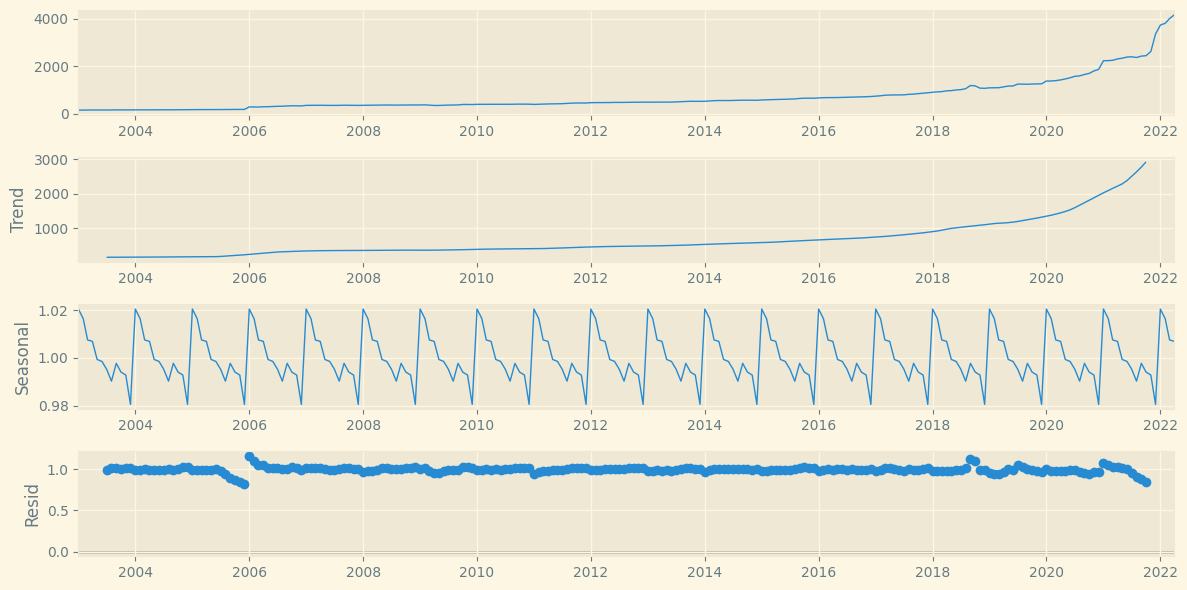

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')


rcParams['figure.figsize'] = 12, 6
plt.rc('lines', linewidth=1, color='r')

fig = result.plot()
#print(plt.style.available)

In [53]:
from pmdarima.arima import auto_arima

results = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2378.959, Time=0.86 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2389.454, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2385.942, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2386.596, Time=0.21 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2377.481, Time=0.13 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2379.007, Time=0.41 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2384.887, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2384.447, Time=0.04 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=2378.928, Time=0.29 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=2378.855, Time=0.26 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=2386.849, Time=0.09 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=2385.784, Time=0.10 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,1,0)[12] inte

In [54]:
results.aic()

2377.4812541250762

Decomposition separate HICP time series into distinct trend, seasonal, and residual components. The trend part reflects the long-term movement of the series, the seasonal part represents the changes with fixed and known periodicity and the residual part explains the non-periodic fluctuations, noisy or random movements.
 
From the Trend component we see that trend is ascending, means HICP index values is raising over time. Residual element has irregularity, becouse inflation depends on various macroeconomical factors , that are unpredictable. We can clearly see the seasonal component of the data (seasonal curve changes in similar pattern over the years). 

performing SARIMAX

from pmdarima.arima import auto_arima

results = auto_arima(df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Output:

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-207.919, BIC=-190.039, Fit time=5.216 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-117.138, BIC=-109.987, Fit time=0.221 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-181.787, BIC=-167.484, Fit time=2.397 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-206.754, BIC=-192.450, Fit time=3.183 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-205.920, BIC=-184.465, Fit time=9.125 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-133.752, BIC=-119.448, Fit time=0.653 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-205.921, BIC=-184.465, Fit time=18.838 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-206.007, BIC=-180.976, Fit time=24.981 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-205.966, BIC=-184.511, Fit time=9.201 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-209.675, BIC=-195.371, Fit time=2.874 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=-207.683, BIC=-189.804, Fit time=4.764 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-134.066, BIC=-123.339, Fit time=0.293 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=-207.686, BIC=-189.806, Fit time=12.029 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=-207.554, BIC=-186.098, Fit time=22.281 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-187.616, BIC=-176.888, Fit time=1.497 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-207.916, BIC=-190.036, Fit time=6.031 seconds

Total fit time: 123.596 seconds

results.aic()

Output
-209.6748286967192

SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.Trend Elements: p - Trend autoregression order, d - Trend difference order, q - Trend moving average order. Seasonal Elements: P - Seasonal autoregressive order ,D - Seasonal difference order, Q - Seasonal moving average order and m - The number of time steps for a single seasonal period.

Together, the notation for an SARIMA model is specified as: SARIMA(p,d,q)(P,D,Q)m
               
We used Auto Arima for automaticly identifying best hyperparameters for the trend and seasonal elements. And  the Model perform best with lowest AIC of -209.67, using Trend Elements - 1, 1, 0 and Seasonal Elements - - 0, 1, 1, where m - 12. Those hyperparameters we will fit into the SARIMAX.

In [55]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df.astype(float),
                                order=(1,1,1),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()



c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



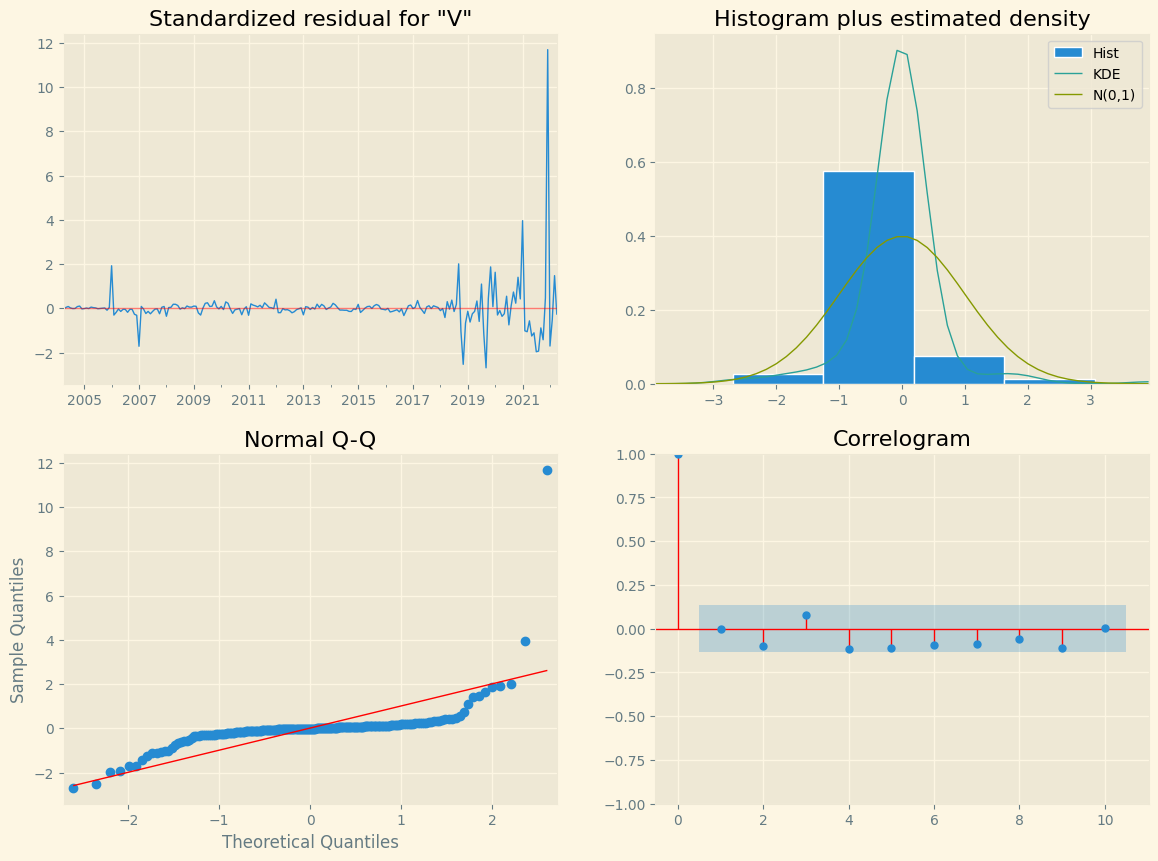

In [56]:
results.plot_diagnostics(figsize=(14,10))
plt.show()

Statespace model result in P>|z| - 0.000, and now our model is turned from non-stationary into stationary.

From diagnostic results plots:
- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [57]:
pred = results.get_prediction(start=pd.to_datetime('2018-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [59]:
pred_ci['Predicted'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2
pred_ci['Observed'] = df['Value']
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Value,upper Value,Predicted,Observed,"Diff, %%"
2021-07-01,2396.940595,2604.648294,2500.794445,2396.654255,4.345232
2021-08-01,2364.988096,2572.693441,2468.840769,2366.266355,4.334863
2021-09-01,2367.763866,2575.466879,2471.615373,2424.568033,1.940442
2021-10-01,2414.190344,2621.891047,2518.040696,2442.594628,3.088767
2021-11-01,2489.827105,2697.525519,2593.676312,2618.650257,-0.953695
2021-12-01,2629.246697,2836.942843,2733.094770,3352.656670,-18.479730
2022-01-01,3711.542132,3919.236033,3815.389082,3724.934816,2.428345
2022-02-01,3724.150990,3931.842665,3827.996827,3800.656652,0.719354
2022-03-01,3816.335644,4024.025114,3920.180379,3998.321061,-1.954337
2022-04-01,4068.387680,4276.074965,4172.231323,4156.745265,0.372552


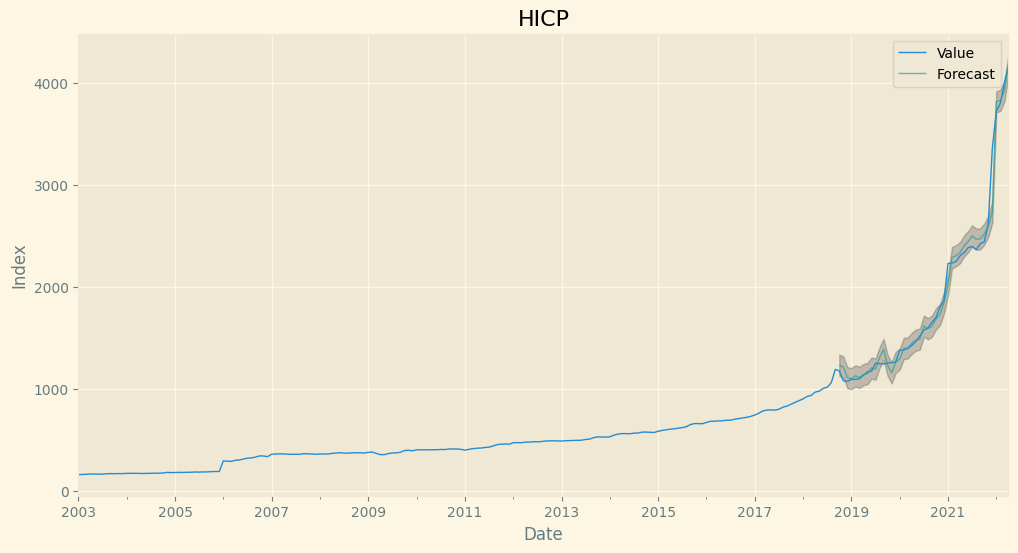

In [60]:
ax = df['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Index')
plt.title("HICP")
plt.legend()
rcParams['figure.figsize'] = 12, 10
plt.show()

In [61]:
# Get forecast 3 years ahead in future
pred_uc = results.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

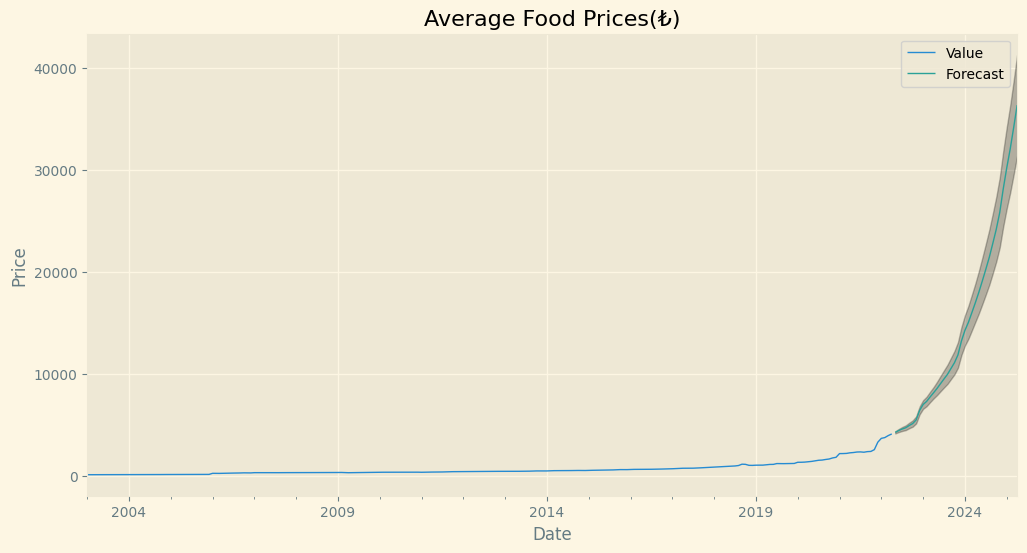

In [62]:
ax = df.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Average Food Prices(₺)")

plt.legend()

plt.show()

In [63]:
pred_ci

,lower Value,upper Value
2022-05-01,4205.838494,4413.523614
2022-06-01,4338.623651,4643.134950
2022-07-01,4449.697229,4836.628100
2022-08-01,4531.480973,4995.339063
2022-09-01,4713.158710,5251.945428
2022-10-01,4865.523185,5479.107862
2022-11-01,5187.019352,5876.466059
2022-12-01,6077.924258,6845.162910
2023-01-01,6619.055862,7466.705588
2023-02-01,6876.189974,7807.459466


Text(0.5, 1.0, 'HICP')

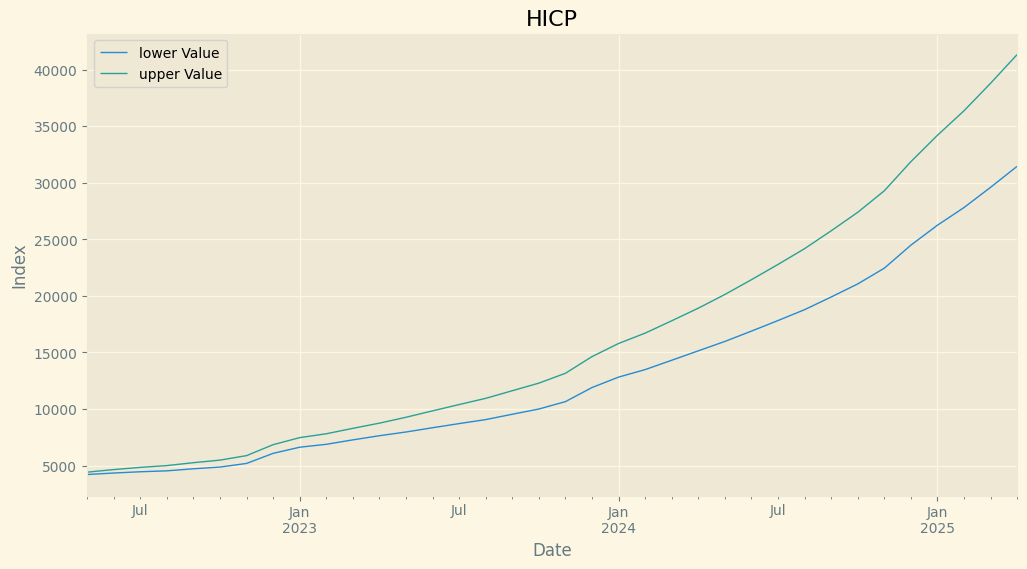

In [64]:
rcParams['figure.figsize'] = 12, 6
pred_ci.head(36).plot()
plt.xlabel('Date')
plt.ylabel('Index')
plt.title("HICP")

In [65]:
pred_ci['Mean'] = (pred_ci['lower Value'] + pred_ci['upper Value'])/2

In [66]:
pred_ci['Mean'].head(20)



2022-05-01     4309.681054
2022-06-01     4490.879301
2022-07-01     4643.162665
2022-08-01     4763.410018
2022-09-01     4982.552069
2022-10-01     5172.315523
2022-11-01     5531.742706
2022-12-01     6461.543584
2023-01-01     7042.880725
2023-02-01     7341.824720
2023-03-01     7777.833968
2023-04-01     8190.750210
2023-05-01     8615.419163
2023-06-01     9086.759739
2023-07-01     9548.841766
2023-08-01     9999.875780
2023-09-01    10572.214366
2023-10-01    11139.102436
2023-11-01    11901.203377
2023-12-01    13260.958039
Freq: MS, Name: Mean, dtype: float64

Text(0.5, 1.0, 'Average Food Prices(₺) Prediction for next 36 months')

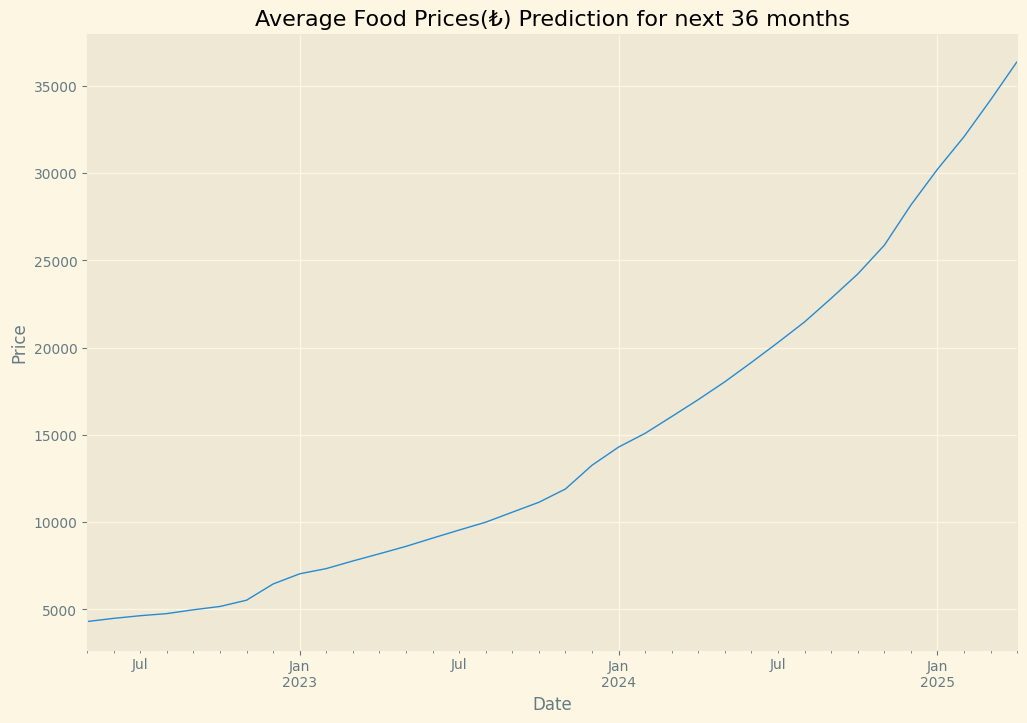

In [69]:
rcParams['figure.figsize'] = 12,8
pred_ci["Mean"].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Average Food Prices(₺) Prediction for next 36 months")